# [Crocoddyl Documentation](https://gepettoweb.laas.fr/doc/loco-3d/crocoddyl/master/doxygen-html/classcrocoddyl_1_1ActuationModelAbstractTpl.html#a9eaa72658ba1c065ecd7efcca8b6af72)

# Introduction

*Experiment*: In this notebook, we leverage crocoddyl's double pendulum model to set up and solve 2R Optimization problem.

*Result*: In our final solutuon, we successfully implementated an activation function in which of the links goes directly to desired state ($x_0 → 1$ ), while the other link's state ($x_2 → 1$) takes the entire time horizon to do.

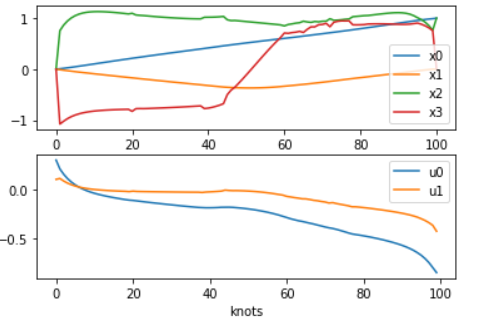

Two major changes have been made to convert double pendulum into 2R Robot:

####1.**Change the actuation Model**

*From:*
`ActuationModelDoublePendulum(state, actLink=1)`

*To:*
`actuation = crocoddyl.ActuationModelFull(state)`

This new model successfully solves the optimization problem ( `xRef = 0,0,0,0`) before the time horizon:

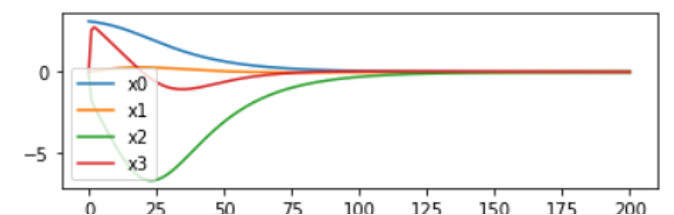



####2.**Add a reference state variable**



### Leveraging Pendulum Cost Function we tried:
------

a.) *Directly passing reference into pendulum function*
* Cannot use CostModelDoublePendulum as it does not accept reference as parameter

---------

b.) Using `ActivationModelWeightedQuad` outside of the Cost Model Double Pendulum
	* `Error: Invalid argument: nr is equals to 4` (nr = dimension of cost)
  * Change the activation function 
    * From: `np.array([1.] * 4 + [0.1] * 2)`
    * To: `np.array([1.] * 4)`

Problems:

a.) Model still wait until end of time horizon to spike towards reference state

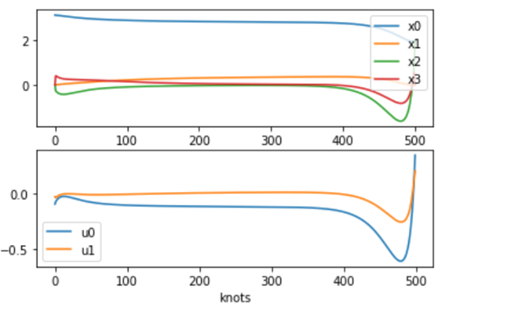


b.) Model incurs a high cost in the beginning, and then almost 0 cost over the rest of the time frame

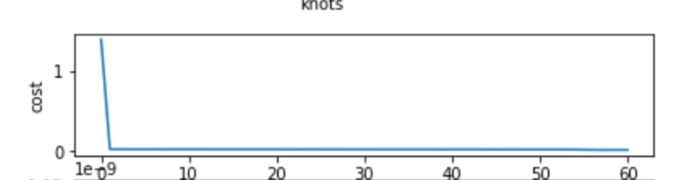


### Creating our own activation function we tried:

a.) *Creating our own quadratic activation cost*
* Same implementation as `xRegCost` already

b.) *Creating quadratic barrier activation cost*
* Idea: Put a quadratic barrier to heavlily penalize distance for fast velocity and high residual from `xRef`
* Both controls and states still spiking at the end



### Final Solution: Weighted Quadratic Barrier Cost
*Idea:*

What if we try a weighed quadratic instead, that greatly punished xv-Residual at each point in time? Perhaps that would incentivize model to go to reference as quickly as possible?

*Implementation:*
```python
bounds = crocoddyl.ActivationBounds(lb, ub) 
w = np.array([1.5]*4) # weight matrix
xQuadBar = crocoddyl.ActivationModelWeightedQuadraticBarrier(bounds, w)
xBarCost = crocoddyl.CostModelResidual(state, xQuadBar, xResidual)
```



*Comparison:* The Quadratic Barrier activation function seems to perform much better than just Quadratic Activation function.
* Using `ActivationModelWeightedQuadraticBarrier`, one link immediately goes to reference state, and other link linearly progresses to the referece state
* Using `xRegCost` both links take entire time horizon to go to reference state.




# Implementation

In [ ]:
%%capture
!pip install crocoddyl

/usr/local/lib/python3.7/dist-packages/pinocchio/shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


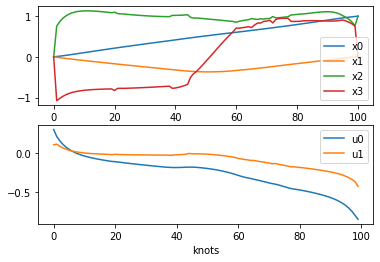

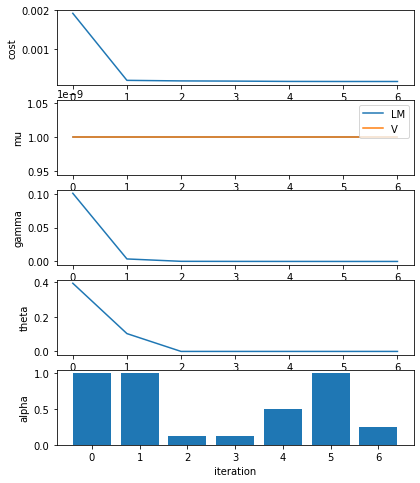

In [ ]:
import os
import sys
import crocoddyl
import numpy as np
import example_robot_data
from crocoddyl.utils.pendulum import CostModelDoublePendulum, ActuationModelDoublePendulum

WITHDISPLAY = 'display' in sys.argv or 'CROCODDYL_DISPLAY' in os.environ
WITHPLOT = 'plot' in sys.argv or 'CROCODDYL_PLOT' in os.environ
WITHPLOT = True

# Loading the double pendulum model
pendulum = example_robot_data.load('double_pendulum')
model = pendulum.model

state = crocoddyl.StateMultibody(model)
actuation = crocoddyl.ActuationModelFull(state)

nu = actuation.nu
runningCostModel = crocoddyl.CostModelSum(state, nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu)

xRef =  np.array([1, 0, 1, 0])
xResidual = crocoddyl.ResidualModelState(state, xRef, nu)
xActivation = crocoddyl.ActivationModelWeightedQuad(np.array([.1] * 4))

z = .7
lb = np.array(xRef) + np.array([-z, -z, -z, -z])
ub = np.array(xRef) + np.array([z, z, z, z])
bounds = crocoddyl.ActivationBounds(lb, ub)

x = 1.5
w = np.array([x]*4)

xQuadBar = crocoddyl.ActivationModelWeightedQuadraticBarrier(bounds, w)
xBarCost = crocoddyl.CostModelResidual(state, xQuadBar, xResidual)

uResidual = crocoddyl.ResidualModelControl(state, nu)
xRegCost = crocoddyl.CostModelResidual(state, xActivation, xResidual)
uActivation = crocoddyl.ActivationModelWeightedQuad(np.array([0.1] * 2))
uRegCost = crocoddyl.CostModelResidual(state, uActivation, uResidual)

# xPendCost = CostModelDoublePendulum(state, crocoddyl.ActivationModelWeightedQuad(np.array([1.] * 4 + [0.1] * 2)), nu)

dt = 1e-2

runningCostModel.addCost("uReg", uRegCost, 1e-4 / dt)
# runningCostModel.addCost("xGoal", xRegCost, 1e-3 / dt)
runningCostModel.addCost("xBar", xBarCost, 1e-6 / dt)
terminalCostModel.addCost("xGoal", xRegCost, 100.)

runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCostModel), dt)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel), dt)

# Creating the shooting problem and the FDDP solver
T = 100
x0 = np.array([0, 0., 0., 0.])
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)
solver = crocoddyl.SolverFDDP(problem)

cameraTF = [1.4, 0., 0.2, 0.5, 0.5, 0.5, 0.5]
if WITHDISPLAY and WITHPLOT:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHPLOT:
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
else:
    solver.setCallbacks([crocoddyl.CallbackVerbose()])

# Solving the problem with the FDDP solver
solver.solve()

# Plotting the entire motion
if WITHPLOT:
    log = solver.getCallbacks()[0]
    crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
    crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Display the entire motion
if WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, floor=False)
    display.displayFromSolver(solver)


Alternative solution:

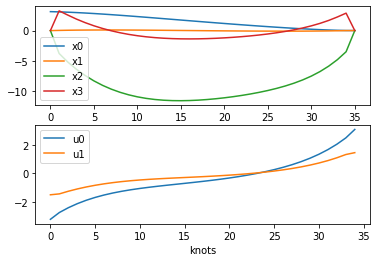

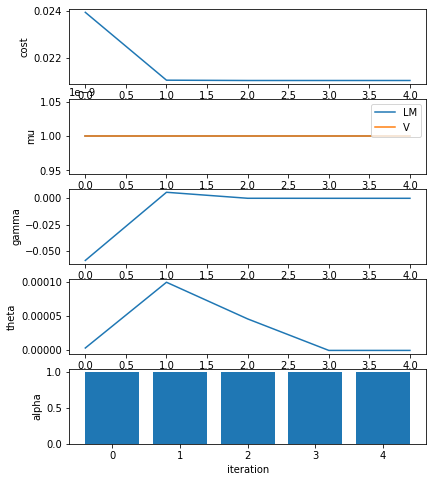

In [ ]:
import os
import sys

import crocoddyl
import numpy as np
import example_robot_data
from crocoddyl.utils.pendulum import CostModelDoublePendulum, ActuationModelDoublePendulum

WITHDISPLAY = 'display' in sys.argv or 'CROCODDYL_DISPLAY' in os.environ
WITHPLOT = 'plot' in sys.argv or 'CROCODDYL_PLOT' in os.environ
WITHPLOT = True

# Loading the double pendulum model
pendulum = example_robot_data.load('double_pendulum')
model = pendulum.model

state = crocoddyl.StateMultibody(model)
actuation = crocoddyl.ActuationModelFull(state)

nu = actuation.nu
runningCostModel = crocoddyl.CostModelSum(state, nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu)

xResidual = crocoddyl.ResidualModelState(state, state.zero(), nu)
xActivation = crocoddyl.ActivationModelQuad(state.ndx)
uResidual = crocoddyl.ResidualModelControl(state, nu)
xRegCost = crocoddyl.CostModelResidual(state, xActivation, xResidual)
uRegCost = crocoddyl.CostModelResidual(state, uResidual)

dt = 1e-2

runningCostModel.addCost("uReg", uRegCost, 1e-4 / dt)
runningCostModel.addCost("xGoal", xRegCost, 1e-5 / dt)
terminalCostModel.addCost("xGoal", xRegCost, 100.)

runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCostModel), dt)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel), dt)

# Creating the shooting problem and the FDDP solver
T = 35
x0 = np.array([3.14, 0., 0., 0.])
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)
solver = crocoddyl.SolverFDDP(problem)

cameraTF = [1.4, 0., 0.2, 0.5, 0.5, 0.5, 0.5]
if WITHDISPLAY and WITHPLOT:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHPLOT:
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
else:
    solver.setCallbacks([crocoddyl.CallbackVerbose()])

# Solving the problem with the FDDP solver
solver.solve()

# Plotting the entire motion
if WITHPLOT:
    log = solver.getCallbacks()[0]
    crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
    crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Display the entire motion
if WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, floor=False)
    display.displayFromSolver(solver)